<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/introduction-to-machine-learning-for-finance/blob/main/2022/1-notebooks/chapter-4-1.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Supervised Models: Linear and Logistic Regression

## Linear Regression

Despite its simplicity, a good understanding of linear regression is prerequisite for understanding how more advanced models work. Generally speaking, a linear model makes a prediction by simply computing a weighted
sum of the input features, plus a constant called the *bias* term (also called the *intercept*
term):

\begin{equation}
Y = a + b_1 X_1 + b_2 X_2 + \dots + b_m X_m + \epsilon
\end{equation}

where:

- $Y$ is the predicted value (the value of the target);
- $m$ is the number of features;
- $X_i$ is the $i^{th}$ feature value that are used to predict $Y$;
- $a$ and $b_j$ are the $j^{th}$ model parameters ($a$ being the bias term and $b_i$ the weights)
- $\epsilon$ is the predicton error.

As usual the parameters $a$ and $b_i$ are chosen to minimize the mean squared error over the training data set. 

This means that the task in linear regression is to find values for $a$ and $b_i$ that minimize

\begin{equation}
MSE = \frac{1}{n} \sum\limits_{i=1}^n \left( Y - a - b_1 X_{i1} - b_2 X_{i2} - \dots - b_m X_{im} \right)^2
\end{equation}

where $n$ is the size of the training set. 

Training a model means setting its parameters so that the model best fits the training set. 

## Example 1 - Predicting Iowa House Prices (from Kaggle)

In [1]:
# loading packages 

import os

import pandas as pd
import numpy as np

# plotting packages
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs

# Kmeans algorithm from scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

#### The Problem

The **Iowa House Pricing Dataset** from Kaggle is a popular dataset used for regression problems, particularly in the context of machine learning. It contains comprehensive information on houses in Ames, Iowa, and their sale prices, and it was designed to serve as an alternative to the Boston Housing Dataset. Here's a brief overview:

**Dataset Overview**

- **Target Variable**: `SalePrice` – the final price of the house in USD.
- **Number of Rows (Observations)**: 2,930 (combined training and test datasets).
- **Number of Features (Columns)**: 79 explanatory variables plus the target variable.

**Types of Features**

The dataset includes a mix of:
1. **Numerical Features**:
   - Continuous (e.g., `LotArea`, `GrLivArea`, `SalePrice`).
   - Discrete (e.g., `GarageCars`, `TotRmsAbvGrd`).

<p></p>

2. **Categorical Features**:
   - Nominal (e.g., `Neighborhood`, `HouseStyle`).
   - Ordinal (e.g., `ExterQual`, `KitchenQual`).

<p></p>

3. **Temporal Features**:
   - Year-based (e.g., `YearBuilt`, `YrSold`).

<p></p>

4. **Location Features**:
   - Specific location details (e.g., `Neighborhood`, `MSSubClass`).

<p></p>

**Key Feature Examples**

- **LotArea**: Size of the lot in square feet.
- **OverallQual**: Overall material and finish quality (ordinal, scale of 1-10).
- **YearBuilt**: Original construction date.
- **GrLivArea**: Above ground living area in square feet.
- **GarageArea**: Size of the garage in square feet.
- **Neighborhood**: Physical locations within Ames city limits.

**Challenges and Use Cases**

The dataset is widely used for:
- **Regression Tasks**: Predicting house prices based on features.
- **Feature Engineering**: Handling missing data, scaling, encoding, and creating new features.
- **Exploratory Data Analysis (EDA)**: Investigating relationships between variables and target.
- **Model Evaluation**: Using metrics like RMSE and R².

The dataset's richness and diversity make it an excellent resource for learning and practicing data analysis and predictive modeling techniques.

#### Categorical Features (See Chapter 2-1)

Categorical features are features where there are a number of non-numerical alternatives. We can define a dummy variable for each alternative. The variable equals 1 if the alternative is true and zero otherwise. This is known as **one-hot encoding**.
But sometimes we do not have to do this because there is a natural ordering of variables. For example in this problem one of the categorical features is concerned with the basement quality as indicated by the ceiling height. The categories are:

- *Excellent (< 100 inches)*
- *Good (90-99 inches)*
- *Typical (80-89 inches)*
- *Fair (70-79 inches)*
- *Poor (< 70 inches)*
- *No Basement*

This is an example of a categorical variable where *there is* a natural ordering. We created a new variable that had a values of 5, 4, 3, 2, 1 and 0 for the above six categories respectively.

The other categorical features specifies the location of the house as in one of 25 neighborhoods. We introduce 25 dummy variables with a one-hot encoding. The dummy variable equals one for an observation if the neighborhood is that in which the house is located and zero otherwise.

#### Loading data (J. C. Hull, 2019, Chapter 3)

To illustrate the regression techniques discussed in this chapter we will use a total of 48 feature. 21 are numerical and two are categorical and to this we had, as discussed above, 25 categorical variables for the neighborhoods. 

In [2]:
#
# upload file 'Houseprice_data_scaled.csv'
#
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()
    path = ''
else:
    path = './data/'

In [3]:
# Both features and target have already been scaled: mean = 0; SD = 1
data = pd.read_csv(path + 'Houseprice_data_scaled.csv') 
data.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,OLDTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Bsmt Qual,Sale Price
0,-0.199572,0.652747,-0.512407,1.038851,0.875754,0.597837,-0.937245,-0.482464,-0.808820,1.203988,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.358489
1,-0.072005,-0.072527,2.189741,0.136810,-0.432225,1.218528,-0.635042,0.490326,0.276358,-0.789421,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,10.905682,0.584308,0.008849
2,0.111026,0.652747,-0.512407,0.972033,0.827310,0.095808,-0.296754,-0.329118,-0.637758,1.231999,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.552733
3,-0.077551,0.652747,-0.512407,-1.901135,-0.722887,-0.520319,-0.057698,-0.722067,-0.528171,0.975236,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,-0.577852,-0.528560
4,0.444919,1.378022,-0.512407,0.938624,0.730423,0.481458,-0.170461,0.209990,-0.036366,1.668495,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.895898


First of all check how many records we have

In [4]:
print("Number of available data = "  + str(len(data.index)))

Number of available data = 2908


Before starting we emphasize the need to divide all available data into three parts: a **training set**, a **validation set** and a **test set**. The training set is used to determine parameters for trial models. The validation set is used to determine the extent to which the models created from the training set generalize to new data. Finally, the test set is used as a final estimate of the accuracy of the chosen model. 

We had 2908 observations. We split this as follows: 1800 in the training set, 600 in the validation set and 508 in the test set.

In [5]:
# First 1800 data items are training set; the next 600 are the validation set
train = data.iloc[:1800] 
val   = data.iloc[1800:2400]

We now procede to create **labels** and **features**. As we have already said, the labels are the values of the target that is to be predicted, in this case the 'Sale Price', and we indicate that whit 'y':

In [6]:
y_train, y_val = train[['Sale Price']], val[['Sale Price']] 

The features and dummy variables were scaled using the Z-score method. Also the target values (i.e. the house prices) have been scaled with the Z-score method. The features are the variables from which the predictions are to be made and, in this case, can be obtained simply dropping the column 'Sale Price' from our dataset:

In [7]:
X_train, X_val = train.drop('Sale Price', axis=1), val.drop('Sale Price', axis=1)

In [8]:
X_train.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr',
       'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV',
       'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NriddgHt', 'NWAmes',
       'OLDTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
       'Veenker', 'Bsmt Qual'],
      dtype='object')

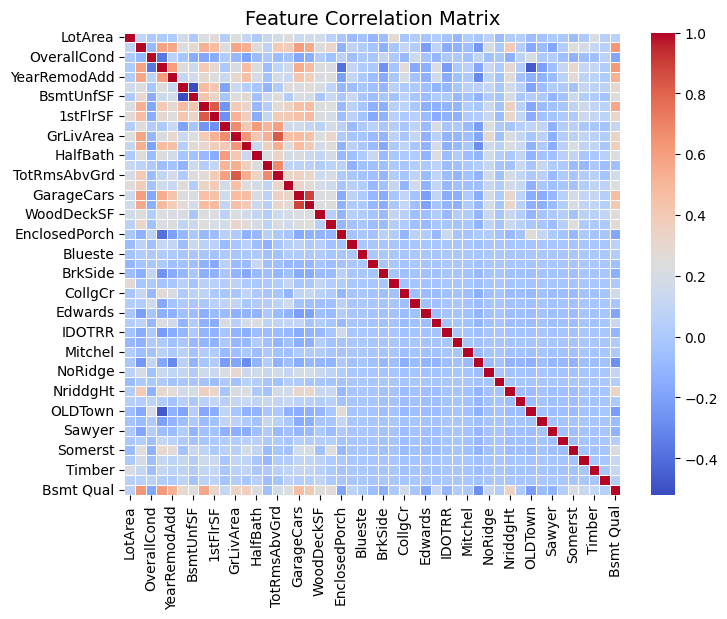

In [9]:
import seaborn as sns

# Compute the correlation matrix
correlation_matrix = X_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with seaborn
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add a title
plt.title("Feature Correlation Matrix", fontsize=14)

# Show the heatmap
plt.show()

#### Linear Regression with sklearn

In [10]:
# Importing models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [11]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [12]:
lr.intercept_

array([-13.964553])

In [13]:
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lr.intercept_) + list(lr.coef_[0])
    ]
)
coeffs

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,intercept,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,NWAmes,OLDTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Bsmt Qual
1,-13.964553,0.078992,0.214373,0.096453,0.160767,0.025413,0.091469,-0.03309,0.138208,0.152738,...,-34807203860.534561,-42129258694.943253,-21313395987.016525,-34073419251.635921,-32544783746.119419,-39782808798.238708,-20002564928.934692,-23702942194.915005,-14442492438.748749,0.011291


In [14]:
# Create dataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lr.intercept_) + list(lr.coef_[0])
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-13.964553
LotArea,0.078992
OverallQual,0.214373
OverallCond,0.096453
YearBuilt,0.160767
YearRemodAdd,0.025413
BsmtFinSF1,0.091469
BsmtUnfSF,-0.03309
TotalBsmtSF,0.138208


In [15]:
coeffs.columns = ['coefficient']

# Reset the index to turn the variable names into a column
coeffs = coeffs.reset_index()
coeffs.columns = ['variable', 'coefficient']

# Decide how many column blocks you want to split the table into
num_blocks = 3

# Compute the number of rows per block (rounding up)
num_rows = int(np.ceil(len(coeffs) / num_blocks))

# Create an empty DataFrame to hold the reshaped data
reshaped = pd.DataFrame()

# Build each block and concatenate them side by side
for i in range(num_blocks):
    start = i * num_rows
    end = start + num_rows
    block = coeffs.iloc[start:end].reset_index(drop=True)
    # Rename the columns to indicate block number
    block.columns = [f'variable_{i+1}', f'coefficient_{i+1}']
    reshaped = pd.concat([reshaped, block], axis=1)

In [16]:
reshaped.head(100)

,variable_1,coefficient_1,variable_2,coefficient_2,variable_3,coefficient_3
0,intercept,-13.964553,Fireplaces,0.028249,MeadowV,-17059843021.876509
1,LotArea,0.078992,GarageCars,0.038006,Mitchel,-28973311789.084454
2,OverallQual,0.214373,GarageArea,0.051799,Names,-59129383311.436089
3,OverallCond,0.096453,WoodDeckSF,0.020814,NoRidge,-25334789268.276417
4,YearBuilt,0.160767,OpenPorchSF,0.034085,NPkVill,-15366591335.829041
5,YearRemodAdd,0.025413,EnclosedPorch,0.006796,NriddgHt,-37566244181.487785
6,BsmtFinSF1,0.091469,Blmngtn,-16236266435.909922,NWAmes,-34807203860.534561
7,BsmtUnfSF,-0.03309,Blueste,-7481015783.291741,OLDTown,-42129258694.943253
8,TotalBsmtSF,0.138208,BrDale,-16653380621.716551,SWISU,-21313395987.016525
9,1stFlrSF,0.152738,BrkSide,-30075585580.560863,Sawyer,-34073419251.635921


The issue you're observing—reasonable coefficients for numerical variables but extremely large coefficients for categorical variables (after one-hot encoding and Z-score normalization)—is likely due to a combination of the following factors:

**1. Effect of One-Hot Encoding on Feature Scaling**

- When you apply **one-hot encoding**, each category is converted into a separate binary (0 or 1) column.
- Then, you applied **Z-score normalization**, which standardizes each feature by subtracting the mean and dividing by the standard deviation:
  
  $$
  X_{\text{scaled}} = \frac{X - \mu}{\sigma}
  $$
  
- The issue arises because the categorical variables, after one-hot encoding, consist of only **0s and 1s**. Their mean is often close to 0, and their standard deviation is relatively small.
- As a result, **Z-score normalization can generate very large values** for these features, leading to inflated regression coefficients.

**2. Interpretation of Large Coefficients**

- Since **one-hot encoded features are binary (0 or 1)**, their standard deviation is not the same as numerical features (which have a wider range).
- **Dividing by a small standard deviation during normalization amplifies the values**, making the model compensate by assigning large coefficients to these categorical variables.
- Unlike numerical features (which vary over a continuous range), categorical features can have much lower standard deviation values, which results in much higher scaling factors.

**3. Potential Solutions**

**Option 1: Normalize Only the Numerical Features**
- One-hot encoded categorical variables are already in a comparable range (0 or 1).
- Instead of applying Z-score normalization to everything, try **normalizing only the numerical variables**, leaving categorical ones unchanged:
  ```python
  from sklearn.preprocessing import StandardScaler
  
  # Separate numerical and categorical features
  numerical_features = X_train.select_dtypes(include=['float64', 'int64'])
  categorical_features = X_train.select_dtypes(include=['uint8'])  # One-hot encoded
  
  # Apply Z-score normalization only to numerical features
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(numerical_features)
  
  # Concatenate back with categorical features (without scaling)
  X_train_final = np.hstack((X_train_scaled, categorical_features.values))
  ```

**Option 2: Use Min-Max Scaling Instead of Z-score**

- If you want to normalize everything, you can try **Min-Max Scaling** instead of Z-score:
  ```python
  from sklearn.preprocessing import MinMaxScaler
  
  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  ```

**Option 3: Use Ridge Regression (L2 Regularization)**

- If the large coefficients are affecting performance, you can try using **Ridge Regression** to shrink them:
  ```python
  from sklearn.linear_model import Ridge
  
  model = Ridge(alpha=1.0)  # Adjust alpha for regularization strength
  model.fit(X_train, y_train)
  ```

The best solution is to **normalize only numerical features**, leaving categorical features unchanged.

In [17]:
# Both features and target have already been scaled: mean = 0; SD = 1
data = pd.read_csv(path + 'Houseprice_data_partial_scaled.csv', sep=';') 
data.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,OLDTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Bsmt Qual,Sale Price
0,-0.199572,0.652747,-0.512407,1.038851,0.875754,0.597837,-0.937245,-0.482464,-0.808820,1.203988,...,0,0,0,0,0,0,0,0,0.584308,0.358489
1,-0.072005,-0.072527,2.189741,0.136810,-0.432225,1.218528,-0.635042,0.490326,0.276358,-0.789421,...,0,0,0,0,0,0,0,1,0.584308,0.008849
2,0.111026,0.652747,-0.512407,0.972033,0.827310,0.095808,-0.296754,-0.329118,-0.637758,1.231999,...,0,0,0,0,0,0,0,0,0.584308,0.552733
3,-0.077551,0.652747,-0.512407,-1.901135,-0.722887,-0.520319,-0.057698,-0.722067,-0.528171,0.975236,...,0,0,0,0,0,0,0,0,-0.577852,-0.528560
4,0.444919,1.378022,-0.512407,0.938624,0.730423,0.481458,-0.170461,0.209990,-0.036366,1.668495,...,0,0,0,0,0,0,0,0,0.584308,0.895898


In [18]:
# First 1800 data items are training set; the next 600 are the validation set
train = data.iloc[:1800] 
val = data.iloc[1800:2400]
y_train, y_val = train[['Sale Price']], val[['Sale Price']] 
X_train, X_val = train.drop('Sale Price', axis=1), val.drop('Sale Price', axis=1)
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.intercept_
# Create dataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lr.intercept_) + list(lr.coef_[0])
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-0.008295
LotArea,0.079
OverallQual,0.214395
OverallCond,0.096479
YearBuilt,0.160799
YearRemodAdd,0.025352
BsmtFinSF1,0.091466
BsmtUnfSF,-0.03308
TotalBsmtSF,0.138199


In [19]:
coeffs.columns = ['coefficient']

# Reset the index to turn the variable names into a column
coeffs = coeffs.reset_index()
coeffs.columns = ['variable', 'coefficient']

# Decide how many column blocks you want to split the table into
num_blocks = 3

# Compute the number of rows per block (rounding up)
num_rows = int(np.ceil(len(coeffs) / num_blocks))

# Create an empty DataFrame to hold the reshaped data
reshaped = pd.DataFrame()

# Build each block and concatenate them side by side
for i in range(num_blocks):
    start = i * num_rows
    end = start + num_rows
    block = coeffs.iloc[start:end].reset_index(drop=True)
    # Rename the columns to indicate block number
    block.columns = [f'variable_{i+1}', f'coefficient_{i+1}']
    reshaped = pd.concat([reshaped, block], axis=1)

In [20]:
reshaped.head(100)

,variable_1,coefficient_1,variable_2,coefficient_2,variable_3,coefficient_3
0,intercept,-0.008295,Fireplaces,0.028258,MeadowV,-0.142466
1,LotArea,0.079,GarageCars,0.037997,Mitchel,-0.145749
2,OverallQual,0.214395,GarageArea,0.051809,Names,-0.093044
3,OverallCond,0.096479,WoodDeckSF,0.020834,NoRidge,0.333643
4,YearBuilt,0.160799,OpenPorchSF,0.034098,NPkVill,-0.216508
5,YearRemodAdd,0.025352,EnclosedPorch,0.006822,NriddgHt,0.534612
6,BsmtFinSF1,0.091466,Blmngtn,-0.169907,NWAmes,-0.225795
7,BsmtUnfSF,-0.03308,Blueste,-0.263946,OLDTown,-0.089516
8,TotalBsmtSF,0.138199,BrDale,-0.224482,SWISU,-0.020487
9,1stFlrSF,0.152786,BrkSide,0.120029,Sawyer,-0.074143


In [21]:
len(coeffs.index)

48

In [22]:
pred_t=lr.predict(X_train)
mse(y_train,pred_t)

0.11401526431246334

In [23]:
pred_v=lr.predict(X_val)
mse(y_val,pred_v)

0.11702499460121663

For the data we are considering it turns out that this regression model generalizes well. The mean squared error for the validation set was only a little higher than that for the training set. However linear regression with no regularization leads to some strange results because of the correlation between features. For example it makes no sense that the weights for number of full bathrooms and number of bedrooms are negative!

In [24]:
x1 = X_train['GrLivArea']
x2 = X_train['BedroomAbvGr']
x1.corr(x2)

0.5347396038733939

###### Ridge Regression

We try using Ridge regression with different values of the hyperparameter $\lambda$. The following code shows the effect of this parameter on the prediction error. 

In [25]:
from sklearn.linear_model import Ridge  # Import the Ridge regression model from scikit-learn

# Define a list of regularization parameters (alphas) to test
# These values are scaled multiples of 1800 (e.g., 0.01 * 1800, 0.02 * 1800, etc.)
alphas = [0.01 * 1800, 0.02 * 1800, 0.03 * 1800, 0.04 * 1800, 
          0.05 * 1800, 0.075 * 1800, 0.1 * 1800, 0.2 * 1800, 0.4 * 1800]
mses = []  # List to store the Mean Squared Error (MSE) for each alpha
# Iterate over each alpha value
for alpha in alphas:
    # Initialize the Ridge regression model with the current alpha value
    ridge = Ridge(alpha=alpha)
    # Train the Ridge regression model on the training dataset
    ridge.fit(X_train, y_train)
    # Predict the target values for the validation dataset
    pred = ridge.predict(X_val)
    # Compute the Mean Squared Error (MSE) for the validation predictions
    mse_val = mse(y_val, pred)  # mse function is assumed to be defined elsewhere
    # Append the computed MSE to the mses list
    mses.append(mse_val)
    # Print the MSE for the current model
    print(mse_val)

0.1178232723779626
0.11936467367295796
0.12086755010152037
0.12227290956225968
0.12358363225088008
0.12652407860501824
0.12911094794424444
0.137559886869908
0.15070876516444884


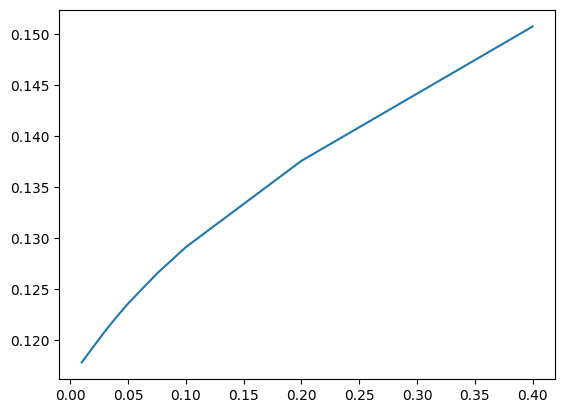

In [26]:
plt.plot(np.array(alphas)/1800, mses)

As expected the prediction error increases as $\lambda$ increases. Values of $\lambda$ in the range $0$ to $0.1$ might be reasonably be considered because prediction errors increases only slightly when $\lambda$ is in this range. However it turns out that the improvement in the model is quite small for these values of $\lambda$.

###### Lasso Regression

In [27]:
# Import Lasso
from sklearn.linear_model import Lasso

In [28]:
# Here we produce results for alpha=0.05 which corresponds to lambda=0.1 in Hull's book
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

Lasso(alpha=0.05)

In [29]:
# DataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lasso.intercept_) + list(lasso.coef_)
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-0.0
LotArea,0.039534
OverallQual,0.32204
OverallCond,0.0
YearBuilt,0.051939
YearRemodAdd,0.065712
BsmtFinSF1,0.117536
BsmtUnfSF,-0.0
TotalBsmtSF,0.11061


###### Lasso with different levels of alpha and its mse

In [30]:
# We now consider different lambda values. The alphas are half the lambdas
alphas=[0.01/2, 0.02/2, 0.03/2, 0.04/2, 0.05/2, 0.06/2, 0.08/2, 0.09/2, 0.1/2]
mses=[]
for alpha in alphas:
    lasso=Lasso(alpha=alpha)
    lasso.fit(X_train,y_train)
    pred=lasso.predict(X_val)
    mses.append(mse(y_val,pred))
    print("lambda = " + '{:<05}'.format(alpha) + " - mse = " + str(round(mse(y_val, pred),6)))

lambda = 0.005 - mse = 0.12258
lambda = 0.010 - mse = 0.129553
lambda = 0.015 - mse = 0.131668
lambda = 0.020 - mse = 0.135273
lambda = 0.025 - mse = 0.139522
lambda = 0.030 - mse = 0.141774
lambda = 0.040 - mse = 0.147001
lambda = 0.045 - mse = 0.148772
lambda = 0.050 - mse = 0.150701


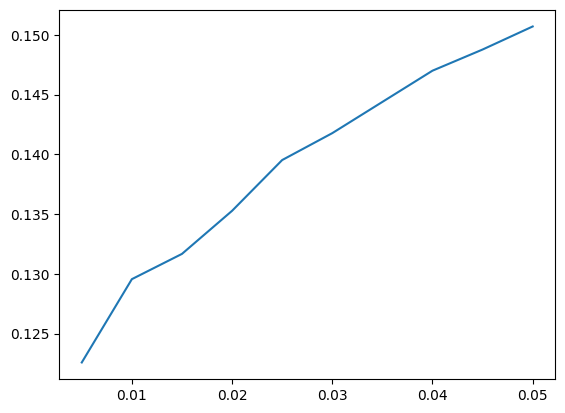

In [31]:
plt.plot(alphas, mses)

Lasso regression leads to more interesting results. In the plot above you can see how the error in the validation set changes as tha value of the lasso $\lambda$ increases. For small values of $\lambda$ the error is actually less than when $\lambda = 0$ but as $\lambda$ increases beyond about $0.03$ the error starts to increase. A value of $\lambda = 0.04$ could be chosen.   

## From Linear to Logistic Regression: Interpolation vs. Classification

**1. Linear Regression: Interpolation**
- **Goal:** Predict a continuous outcome based on input features.
- **Function:** \( y = wX + b \) (straight-line fit)
- **Use Case:** Estimates values between known data points (e.g., predicting house prices).
- **Limitation for Classification:**
  - If used for binary classification, outputs can be any real number, not constrained to \([0,1]\).
  - Poor separation between classes.

**2. Logistic Regression: Classification**
- **Goal:** Predict a categorical outcome (e.g., class 0 or 1).
- **Function:** Uses a **sigmoid function** to map outputs to probabilities:
  \[
  P(y=1|X) = \frac{1}{1 + e^{-(wX + b)}}
  \]
- **Key Difference:**
  - Converts continuous values into probabilities.
  - Decision boundary at \( P(y=1) = 0.5 \) separates classes.
  - Ensures outputs are always between 0 and 1.

**Why This Matters?**
- **Linear Regression** is suited for **interpolation** (continuous prediction).
- **Logistic Regression** is suited for **classification**, ensuring a probabilistic approach to decision-making.


## What is Logistic Regression

### Classification Problem

As we know there are two types of supervised learning models: those that are used to **predict** a numerical variable and those that are used for **classification**. Up to now we have considered the problem of predicting a numerical variable, we now move on to the classification problem. In particular we focus on the so called Binomial Logistic Regression, where the response variable has two values 0 and 1 or pass and fail or true and false. Multinomial Logistic Regression deals with situations where the response variable can have three or more possible values. 

### Why Logistic, not Linear?

With binary classification, let $x$ be some feature and $y$ be the output which can be either 0 or 1.
The probability that the output is 1 given its input can be represented as:

$$P(y=1 \vert x) $$

If we predict the probability via linear regression, we can state it as:

$$P(y=1 \vert x) = \beta_0 + \beta_1 X$$

Linear regression model can generate the predicted probability as any number ranging from negative to positive infinity, whereas probability of an outcome can only lie between 0< P(x)<1.

In [69]:
# Generate a simple synthetic dataset for credit analysis
np.random.seed(42)
num_samples = 100

# Feature: Income (in thousands of dollars)
income_y0 = np.random.normal(loc=25, scale=5, size=num_samples // 2)  # Lower income for y=0
income_y1 = np.random.normal(loc=75, scale=10, size=num_samples // 2)  # Higher income for y=1

# Class labels: y=0 (bad credit) and y=1 (good credit)
y = np.concatenate([np.zeros(num_samples // 2), np.ones(num_samples // 2)])

# Combine into a DataFrame
data = pd.DataFrame({
    "Income": np.concatenate([income_y0, income_y1]),
    "Credit_Status": y.astype(int)  # Convert to integers for clarity
})
data.head()

,Income,Credit_Status
0,27.483571,0
1,24.308678,0
2,28.238443,0
3,32.615149,0
4,23.829233,0


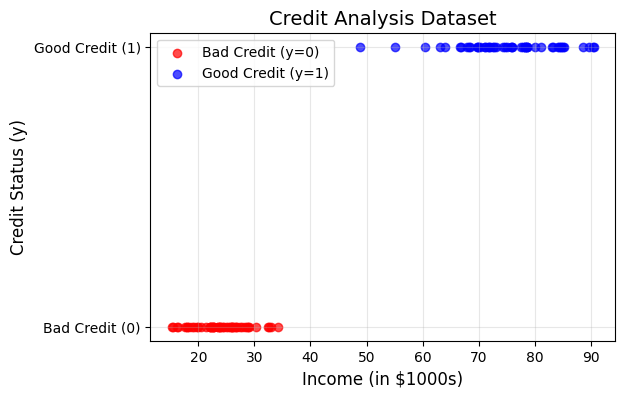

In [70]:
# Plot the dataset
plt.figure(figsize=(6, 4))
plt.scatter(data[data['Credit_Status'] == 0]['Income'], 
            data[data['Credit_Status'] == 0]['Credit_Status'], 
            color='red', label='Bad Credit (y=0)', alpha=0.7)
plt.scatter(data[data['Credit_Status'] == 1]['Income'], 
            data[data['Credit_Status'] == 1]['Credit_Status'], 
            color='blue', label='Good Credit (y=1)', alpha=0.7)
plt.title("Credit Analysis Dataset", fontsize=14)
plt.xlabel("Income (in $1000s)", fontsize=12)
plt.ylabel("Credit Status (y)", fontsize=12)
plt.yticks([0, 1], ['Bad Credit (0)', 'Good Credit (1)'])
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

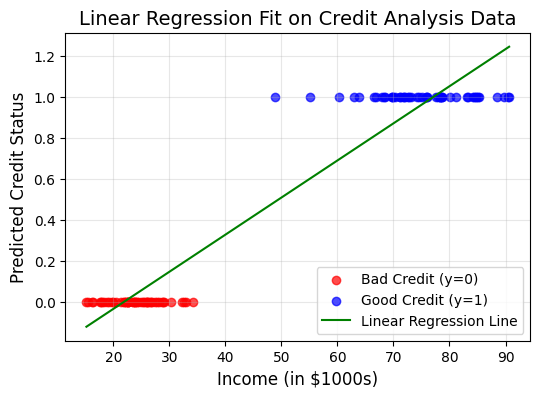

In [71]:
from sklearn.linear_model import LinearRegression

# Train a linear regression model
X = data[['Income']].values  # Feature: Income
y = data['Credit_Status'].values  # Target: Credit_Status
linear_model = LinearRegression()
linear_model.fit(X, y)

# Predict using the linear regression model
x_values = np.linspace(data['Income'].min(), data['Income'].max(), 100).reshape(-1, 1)
y_values = linear_model.predict(x_values)

# Plot the linear regression fit
plt.figure(figsize=(6, 4))
plt.scatter(data[data['Credit_Status'] == 0]['Income'], 
            data[data['Credit_Status'] == 0]['Credit_Status'], 
            color='red', label='Bad Credit (y=0)', alpha=0.7)
plt.scatter(data[data['Credit_Status'] == 1]['Income'], 
            data[data['Credit_Status'] == 1]['Credit_Status'], 
            color='blue', label='Good Credit (y=1)', alpha=0.7)
plt.plot(x_values, y_values, color='green', label='Linear Regression Line')
plt.title("Linear Regression Fit on Credit Analysis Data", fontsize=14)
plt.xlabel("Income (in $1000s)", fontsize=12)
plt.ylabel("Predicted Credit Status", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

To avoid this problem, log-odds function or logit function is used.

### Logit Function

Logistic regression can be expressed as:

\begin{equation}
\log \left( \frac{p(y=1\vert x)}{1-p(y=1\vert x)}\right) = \beta_0 + \beta_1 X
\end{equation}

where, the left hand side is called the *logit* or *log-odds* function, and $p/(1-p)$ is called *odds*. The odds signifies the ratio of probability of success to probability of failure. Therefore, in Logistic Regression, linear combination of inputs are mapped to the log(odds) - the output being equal to 1. If we take an inverse of the above function, we get:

\begin{equation}
Q=p(y=1 \vert x) = \frac{e^{\beta_0 + \beta_1 X}}{1+e^{\beta_0 + \beta_1 X}} = \frac{1}{1+e^{-(\beta_0 + \beta_1 X)}} =
\frac{1}{1+e^{-Y}}
\end{equation}

where $Y= \beta_0 + \beta_1 X$. 

This is known as the **Sigmoid Function** and it gives an S-shaped curve. It always gives a value of probability ranging from $0<p<1$. 

In [72]:
import numpy as np

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [73]:
from sklearn.linear_model import LogisticRegression

In [74]:
# Train a logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X, y)

LogisticRegression()

In [75]:
# Predict using the logistic regression model
y_logistic_values = logistic_model.predict_proba(x_values)[:, 1]

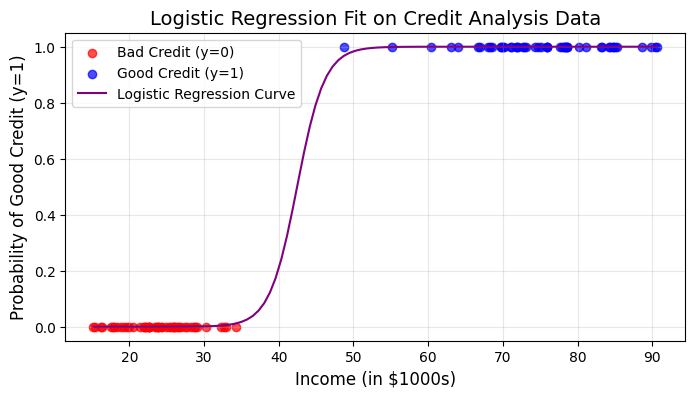

In [76]:
# Plot the logistic regression fit
plt.figure(figsize=(8, 4))  # Resized figure
plt.scatter(data[data['Credit_Status'] == 0]['Income'], 
            data[data['Credit_Status'] == 0]['Credit_Status'], 
            color='red', label='Bad Credit (y=0)', alpha=0.7)
plt.scatter(data[data['Credit_Status'] == 1]['Income'], 
            data[data['Credit_Status'] == 1]['Credit_Status'], 
            color='blue', label='Good Credit (y=1)', alpha=0.7)
plt.plot(x_values, y_logistic_values, color='purple', label='Logistic Regression Curve')
plt.title("Logistic Regression Fit on Credit Analysis Data", fontsize=14)
plt.xlabel("Income (in $1000s)", fontsize=12)
plt.ylabel("Probability of Good Credit (y=1)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

The output of the sigmoid function is then interpreted as the probability of a particular example belonging to class 1, $\Phi(z) = P(y=1 \vert \mathbf{x}; \mathbf{w})$, given its features, $x$, parameterized by the weights, $w$. The predicted probability can then simply be converted into a binary outcome via a threshold function:

$$\hat y = \begin{cases}
              &1 \quad \text{if } \phi(z) \ge 0.5 \\ & 0 \quad \text{otherwise}
              \end{cases}$$

If we look at the preceding plot of the sigmoid function, this is equivalent to the

following:

$$\hat y = \begin{cases}
              &1 \quad \text{if } z \ge 0 \\ & 0 \quad \text{otherwise}
              \end{cases}$$


### Estimation of Regression Coefficients

Unlike linear regression model, that uses Ordinary Least Square for parameter estimation, we use Maximum Likelihood Estimation.
There can be infinite sets of regression coefficients. The maximum likelihood estimate is that set of regression coefficients for which the probability of getting the data we have observed is maximum. In this case we can write simply:

\begin{equation}
{\cal{L}} = \prod\limits_{i=1}^n  Q(\mathbf{\beta}^T \mathbf{x})^{y(i)} \left[ 1 - Q(\mathbf{\beta}^T \mathbf{x})\right]^{1-y(i)} \Rightarrow \log{\cal{L}} = 
\sum\limits_{i=1}^n
\left\{
{y(i)} \cdot \ln Q(\mathbf{\beta}^T \mathbf{x}) 
+ (1-y(i)) \cdot \ln \left[ 1 - Q(\mathbf{\beta}^T \mathbf{x})\right] 
\right\}
\end{equation}

Now since in the binomial case $y_i = 1 \,or\, 0$, we can write

\begin{equation}L=\sum\limits_\text{POS OUT} \, \ln(Q) + \sum\limits_\text{NEG OUT} \, \ln(1-Q) \end{equation}

The first summation is over all the observations which led to positive outcomes and the second summation is over all observations which let to negative outcomes. This function cannot be maximized analytically and gradient ascent (analogous to gradient descent) methods must be used.

Let's write a short code snippet to create a plot that illustrates the cost of classifying
a single training example for different values of $\phi(z)$ :

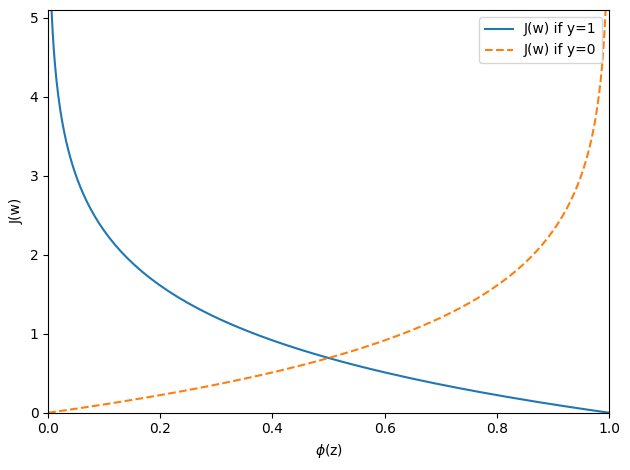

In [77]:
def cost_1(z):
    return - np.log(sigmoid(z))

def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We can see that the cost approaches 0 (continuous line) if we correctly predict that
an example belongs to class 1. Similarly, we can see on the y-axis that the cost also
approaches 0 if we correctly predict y = 0 (dashed line). However, if the prediction
is wrong, the cost goes toward infinity. The main point is that we penalize wrong
predictions with an increasingly larger cost.

## Performance of Logistic Regression model

To evaluate the performance of a logistic regression model, Deviance is used in lieu of sum of squares calculations.

- Null Deviance indicates the response predicted by a model with nothing but an intercept.
- Model deviance indicates the response predicted by a model on adding independent variables. If the model deviance is significantly smaller than the null deviance, one can conclude that the parameter or set of parameters significantly improved model fit.
- Another way to find the accuracy of model is by using Confusion Matrix.

![image.png](./pic/chapter-4-1_pic_2.png)

## Example 2 - Application to Credit Decision 

In this section we consider a subset of the data provided by the company Lending Club on its credit decision. For a complete description see the textbook of J. C. Hull chapter 3, pag. 73.

LENDING CLUB BACKGROUND
Lending Club is a peer-to-peer (P2P) lending platform, where borrowers submit their loan applications and individual lenders select the applications that they want to fund. Borrowers receive the full amount of the issued loan minus the origination fee, which is paid to the company. Investors purchase notes backed by the personal loans and pay Lending Club a service fee.

P2P lending brings down the cost of personal loans compared to traditional financing by connecting the borrowers and investors directly. However, there is always a risk of investing in a bad loan. In fact, the default rate for P2P loans are much higher than that of traditional loans. Therefore, the lending industry is highly interested in providing the investors with comprehensive risk assessment of the loan applications. The company shares data about all loan applications made through its platform. 

### **Interpretation of FICO Scores**

The **FICO** credit score is a three-digit number used by lenders to assess an individual's creditworthiness. It ranges **from 300 to 850**, with higher scores indicating lower credit risk. The score is developed by the Fair Isaac Corporation (FICO) and is widely used in the U.S. for lending decisions, including mortgages, car loans, and credit cards. 

Here is a breakdown of the typical **FICO score categories**:

| **FICO Score Range** | **Credit Rating**       | **Risk Level** |
|----------------------|------------------------|---------------|
| **300 - 579**       | Poor                   | Very High Risk |
| **580 - 669**       | Fair                   | High Risk |
| **670 - 739**       | Good                   | Moderate Risk |
| **740 - 799**       | Very Good              | Low Risk |
| **800 - 850**       | Exceptional            | Very Low Risk |

- **300-579 (Poor)**: Borrowers in this range are often considered **subprime** and may have difficulty obtaining loans. If approved, they will face **high interest rates**.
- **580-669 (Fair)**: Some lenders approve loans for this range, but interest rates will be relatively high.
- **670-739 (Good)**: This is the average credit score range in the U.S., and borrowers typically receive **decent interest rates**.
- **740-799 (Very Good)**: Borrowers in this range qualify for **better loan terms** and lower interest rates.
- **800-850 (Exceptional)**: These borrowers are the **least risky**, qualifying for the **best rates and highest credit limits**.

### **Use in LendingClub**
In the **LendingClub dataset**, borrowers' FICO scores are given as a **range** (e.g., 700-724), with:
- **fico_low**: The lower bound of the range.
- **fico_high**: The upper bound of the range.

This range helps investors assess **borrower risk** when making lending decisions.

In [41]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import openpyxl
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [78]:
#
# load file lendingclub_traindata.xlsx
#
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()
    path = ''
else:
    path = './data/'

In [79]:
#
# load file lendingclub_testdata.xlsx
#
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()

In [81]:
train = pd.read_excel(path + 'lendingclub_traindata.xlsx', engine='openpyxl')
test  = pd.read_excel(path + 'lendingclub_testdata.xlsx', engine='openpyxl')

In [82]:
# 1 = good, 0 = default

# give column names
cols = ['home_ownership', 'income', 'dti', 'fico_low', 'loan_status']
train.columns = test.columns = cols

print(train.head())
print("--------------------------------")
print(test.head())

   home_ownership  income    dti  fico_low  loan_status
0               1  44.304  18.47       690            0
1               0  38.500  33.73       660            0
2               1  54.000  19.00       660            0
3               1  60.000  33.98       695            0
4               0  39.354  10.85       685            0
--------------------------------
   home_ownership  income    dti  fico_low  loan_status
0               1   127.0  10.94       675            0
1               1   197.0  15.64       710            0
2               1    25.5  28.75       670            0
3               1    80.0  20.16       660            0
4               0    57.0  30.60       675            0


For the purposes of this exercise, the dataset has already been split into train and test set. There are 8695 instances of training set and 5916 instances of test set with with four features and one target. The four features are home_ownership, income, dti and fico_low and the target is loan status that includes either fully paid or defaulted loans only. 

In [84]:
# remove target column to create feature only dataset
X_train = train.drop('loan_status', axis=1)
X_test  = test.drop('loan_status', axis=1)

# store target column
y_train = train['loan_status']
y_test  = test['loan_status']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.columns

(8695, 4) (8695,) (5916, 4) (5916,)


Index(['home_ownership', 'income', 'dti', 'fico_low'], dtype='object')

By default the mode() method return the highest frequency value in a Series

### The Problem of Imbalance

The below Python code snippet is evaluating a baseline model in the context of logistic regression training on credit risk data. In our credit risk dataset, the target variable $y$ indicates whether a loan was fully paid (good borrower) or defaulted (risky borrower), represented as a binary classification problem where $y = 1$ corresponds to fully paid loans and $y = 0$ represents defaults. Since credit risk datasets are often imbalanced, meaning that more loans are fully paid than defaulted, a naive strategy is to always predict the majority class, assuming every loan is repaid. 

The code begins by identifying the most frequent class in `y_train` using `y_train.mode()[0]`, which usually results in the majority class being "Fully Paid." Then, it generates predictions using `np.full(shape=y_train.shape, all_value=majority_class)`, creating an array of the same shape as `y_train` where every predicted value is the majority class. 

Finally, the accuracy score is computed by comparing these naive predictions to the actual labels using `accuracy_score(y_train, prediction)`. 

Given that the dataset is imbalanced, this accuracy might appear high, but **it is misleading because the model does not actually identify defaulters**. This approach provides a benchmark accuracy that any logistic regression model should exceed. If a trained model does not perform better than this naive strategy, it is ineffective. 

Logistic regression, when applied to imbalanced datasets, may also struggle, as it tends to favor the majority class. If, for example, 90% of the dataset consists of fully paid loans, then always predicting "Fully Paid" would yield 90% accuracy but completely fail to recall defaulters. Instead of using accuracy alone, it is crucial to evaluate the model with precision, recall, F1-score, and ROC-AUC to get a better measure of performance. 

In [85]:
y_train.mode()[0]

1

In [86]:
majority_class = y_train.mode()[0]        # predict fully paid only
prediction = np.full(shape=y_train.shape, fill_value=majority_class)
accuracy_score(y_train, prediction)

0.8276020701552617

In [87]:
freq = y_train.value_counts()           # count frequency of different classes in loan status
freq/sum(freq)*100                      # get percentage of above

loan_status
1    82.760207
0    17.239793
Name: count, dtype: float64

### Fitting a Logistic Regression

We are ready to implement the **logistic regression** using the `LogisticRegression` class from **scikit-learn** to train a model for out **binary classification problem**

**Step-by-Step Explanation of the Code**

<p>
    
1. **Create an Instance of Logistic Regression**
   ```python
   lgstc_reg =  LogisticRegression(penalty="none", solver='newton-cg')
   ```
   - This initializes a **logistic regression model** with no regularization (`penalty="none"`), meaning that the model does not apply L1 (Lasso) or L2 (Ridge) regularization to prevent overfitting.
   - The solver is set to `'newton-cg'`, which is an **iterative optimization algorithm** suitable for solving logistic regression problems, especially when there are many features. It is **faster and more stable** for solving problems with **second-order derivatives** compared to simpler solvers like `'liblinear'`.

<p>
    
2. **Train the Logistic Regression Model on the Training Data**
   ```python
   lgstc_reg.fit(X_train, y_train)
   ```
   - The `.fit()` method trains the logistic regression model by finding the optimal weights (coefficients) for each feature in `X_train` to best predict `y_train` (which likely contains labels such as **fully paid** vs **default** in a credit risk dataset).
   - This step uses **maximum likelihood estimation (MLE)** to estimate the parameters of the logistic function.
   - Since `penalty="none"`, the model **only minimizes the log-loss function** without additional constraints to prevent overfitting.

<p>
    
3. **Extract and Print Model Parameters**
   ```python
   print(lgstc_reg.intercept_, lgstc_reg.coef_)
   ```
   - `lgstc_reg.intercept_`: Represents the **bias term** (also called the intercept $b$ in the logistic regression equation $ y = \sigma(WX + b) $).
   - `lgstc_reg.coef_`: Contains the **coefficients (weights)** of each feature in `X_train`, which determine how much each feature contributes to the prediction.
   - These coefficients indicate the **direction and magnitude** of each feature's impact on the probability of the positive class (e.g., a higher weight means a stronger influence on predicting default or full repayment).

**Key Insights and Considerations**

    - Since **no regularization** is applied (`penalty="none"`), the model may be **prone to overfitting**, especially if the dataset has many features.
- The choice of **Newton-CG solver** is ideal when working with datasets that have many features because it efficiently computes the second derivative (Hessian matrix) to optimize convergence.
- If the coefficients are very large, it may indicate **multicollinearity** or that regularization is necessary.

In [88]:
# create an instance of logistic regression
lgstc_reg =  LogisticRegression(penalty="none", solver='newton-cg')     

In [89]:
# fit training data on logistic regression 
lgstc_reg.fit(X_train, y_train)                                                             

LogisticRegression(penalty='none', solver='newton-cg')

In [90]:
# get the coefficients of each features
print(lgstc_reg.intercept_, lgstc_reg.coef_)                                                

[-6.56522928] [[ 0.139496    0.00410667 -0.00112302  0.0112521 ]]


<br>
The bias is estimated as -6.56517476. The coefficient of the logistic regression are 0.13949599 for home_ownership, 0.0041 0667 for income, -0.00112303 for dti and 0.01125202 for fico_low. These are the weights (parameters) that maximizes the likelihood of producing our given data and hence gives us the least error in predicting our response variable.

The question of how to evaluate the model is of the utmost importance. This is where we will test the model's performance on an unseen test set and check the results of our chosen measure of success. This step is meant to be representative of how the model might perform in the real world.

**Difference between `predict` and `predict_proba`**

In [91]:
# predict default loans based on test data set
y_pred = lgstc_reg.predict(X_test)  
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [92]:
test = lgstc_reg.predict_proba(X_test)
test

array([[0.15726857, 0.84273143],
       [0.08669251, 0.91330749],
       [0.23404583, 0.76595417],
       ...,
       [0.24464988, 0.75535012],
       [0.1729421 , 0.8270579 ],
       [0.26198361, 0.73801639]])

An analyst must decide on a criterion for predicting whether loan will be good or default. This involves specifying a threshold. 

>**By default this threshold is set to 0.5, i.e., loans are separated into good and bad categories according to whether the probability of no default is greater or less than 0.5. However this does not work well for an imbalanced data set such as this. It would predict that all loans are good! We will look at the results for few other thresholds**. 



From the confusion matrix, we can derive some important metrics

> **Accuracy** is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our > model got right. Formally, accuracy has the following definition:
>
>$$\text{accuracy} = \frac{\text{number of correct predictions}}{\text{total number of predictions}}$$
>
> For binary classification, accuracy can also be calculated in terms of positives and negatives as follows:
>
>$$\text{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
>
> Where TP = True Positives, TN = True Negatives, FP = False Positives, and FN = False Negatives.

> **Precision** attempts to answer the following question: What proportion of positive identifications was actually > correct? Precision is defined as follows:
>
>$$\text{precision} = \frac{TP}{TP+FP}$$

> **Recall** attempts to answer the following question: What proportion of actual positives was identified correctly?
> Mathematically, recall is defined as follows:
>
> $$\text{recall} = \frac{TP}{TP+FN}$$

The below program tests how well our **logistic regression model** works at predicting whether a loan will default or not, by changing the **decision threshold**.

**What does this mean?**

As we have already said, normally, a logistic regression model gives a **probability** between 0 and 1 for each prediction. By default, if this probability is **above 0.5**, we classify it as **1** (e.g., "default"), otherwise, we classify it as **0** (e.g., "no default"). 

But sometimes, **0.5 is not the best threshold**! If we want **fewer false positives** (wrongly predicting default), we can **increase the threshold** (e.g., 0.75, 0.80, 0.85). This makes the model more **cautious** about predicting 1.

**What does the program do?**

1. **Train the model** using the training data.
2. **Test the model** on new data, using different decision thresholds (0.50, 0.75, 0.80, 0.85).
3. **Check how the model performs** at each threshold by:
   - Counting how many correct and incorrect predictions it makes (**confusion matrix**).
   - Measuring accuracy, recall, precision, and other performance scores.
4. **Store the results** in a table and print them.

**Why is this useful?**

By testing different thresholds, we can **find the best trade-off** between detecting true defaults and avoiding false alarms. This is especially important in **finance, medicine, and fraud detection**, where false positives and false negatives have big consequences.

In [93]:
print(X_test.shape)

(5916, 4)


In [94]:
n_test = X_test.shape[0]
print(n_test)

5916


In [104]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
)

# Define different probability thresholds for classification
THRESHOLD = [0.50, 0.75, 0.80, 0.814, 0.85, 0.90]

# Create an empty DataFrame to store performance metrics for each threshold
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "recall", "tnr", "fpr", "precision", "f1_score"])

# Store threshold values in the first column of the results DataFrame
results["THRESHOLD"] = THRESHOLD

# Train logistic regression model using training data
lgstc_reg.fit(X_train, y_train)

# Initialize row index for inserting values in results DataFrame
j = 0

# Iterate over each threshold value
for i in THRESHOLD:
    # Generate predictions: classify as 1 if predicted probability > threshold, otherwise 0
    preds = np.where(lgstc_reg.predict_proba(X_test)[:, 1] > i, 1, 0)
    
    # Compute the confusion matrix, normalized as a percentage (assuming n_test is total test size)
    cm = (confusion_matrix(y_test, preds, labels=[1, 0]) / n_test) * 100
    
    # Print confusion matrix for the current threshold
    print(f'Confusion matrix for threshold = {i}')
    print(cm)
    print(' ')

    # Extract values from confusion matrix
    TP = cm[0][0]  # True Positives
    FN = cm[0][1]  # False Negatives
    FP = cm[1][0]  # False Positives
    TN = cm[1][1]  # True Negatives

    # Calculate and store performance metrics in results DataFrame
    results.iloc[j, 1] = accuracy_score(y_test, preds)  # Accuracy
    results.iloc[j, 2] = recall_score(y_test, preds)  # Recall (Sensitivity)
    results.iloc[j, 3] = TN / (FP + TN)  # True Negative Rate (Specificity)
    results.iloc[j, 4] = FP / (FP + TN)  # False Positive Rate
    results.iloc[j, 5] = precision_score(y_test, preds)  # Precision
    results.iloc[j, 6] = f1_score(y_test, preds)  # F1 Score

    # Move to the next row
    j += 1

# Print all computed metrics in transposed format for readability
print('ALL METRICS')
print(results.T)


Confusion matrix for threshold = 0.5
[[82.11629479  0.        ]
 [17.88370521  0.        ]]
 
Confusion matrix for threshold = 0.75
[[77.5862069   4.5300879 ]
 [16.26098715  1.62271805]]
 
Confusion matrix for threshold = 0.8
[[55.34144692 26.77484787]
 [ 9.75321163  8.13049358]]
 
Confusion matrix for threshold = 0.814
[[48.12373225 33.99256254]
 [ 7.70791075 10.17579446]]
 
Confusion matrix for threshold = 0.85
[[28.65111562 53.46517918]
 [ 3.73563218 14.14807302]]
 
Confusion matrix for threshold = 0.9
[[ 9.1954023  72.92089249]
 [ 1.09871535 16.78498986]]
 
ALL METRICS
                  0         1         2         3         4         5
THRESHOLD       0.5      0.75       0.8     0.814      0.85       0.9
accuracy   0.821163  0.792089  0.634719  0.582995  0.427992  0.259804
recall          1.0  0.944833   0.67394  0.586044  0.348909   0.11198
tnr             0.0  0.090737  0.454631  0.568998  0.791115  0.938563
fpr             1.0  0.909263  0.545369  0.431002  0.208885  0.061437


<br>
We note here from the confusion matrix at threshold 0.75 that while the model is good at identifying good loans, however it isn't good at identifying the bad loans at all.

We also note that increasing the threshold results in decrease in overall accuracy. But the percentage of default loans identified as default is higher with increasing threshold. We know by now that maximizing the accuracy does not necessarily create the best model. Thus, lets look at some other metrics.

In [60]:
print( 'ALL METRICS' )
print( results.T )

ALL METRICS
                  0         1         2         3
THRESHOLD       0.5      0.75       0.8      0.85
accuracy   0.821163  0.792089  0.634719  0.427992
recall          1.0  0.944833   0.67394  0.348909
tnr             0.0  0.090737  0.454631  0.791115
fpr             1.0  0.909263  0.545369  0.208885
precision  0.821163  0.826729  0.850169  0.884656
f1_score   0.901801  0.881844  0.751866  0.500443


### What is the AUC - ROC Curve?

The **AUC-ROC Curve** is a way to **measure how well a classification model can separate two classes** (e.g., "default" vs. "no default" in a loan prediction).

**Breaking It Down:**

- **ROC Curve (Receiver Operating Characteristic Curve)**  
  - It shows how the model's **True Positive Rate (Recall)** changes with the **False Positive Rate** at different thresholds.
  - The curve is created by plotting:
    - **True Positive Rate (Sensitivity / Recall) on the Y-axis**
    - **False Positive Rate (1 - Specificity) on the X-axis**

- **AUC (Area Under the Curve)**  
  - It is the area under the **ROC curve** and tells us how well the model **distinguishes** between the two classes.
  - **AUC = 1.0** → Perfect model (100% accurate).
  - **AUC = 0.5** → Random guessing (useless model).
  - **AUC < 0.5** → Worse than random guessing.

**Why Is It Useful?**

- **Helps compare models**: The higher the AUC, the better the model is at separating classes.
- **Threshold-independent**: Unlike accuracy, which depends on a fixed threshold (e.g., 0.5), the ROC curve **evaluates all possible thresholds**.

The **AUC-ROC Curve** helps you choose the **best sensitivity level** without getting too many false alarms.

![caption](./pic/chapter-4-1_pic_8.png)

### **What is `predict_proba` in Scikit-Learn?**

The `predict_proba` method in **Scikit-Learn** is used to **get the probability estimates** that a given input belongs to each possible class in a classification model.

**How It Works**

When you train a **probabilistic classifier** (like **Logistic Regression, Random Forest, or XGBoost**), the model doesn’t just output a **hard class prediction** (0 or 1). Instead, it calculates **how confident** it is that a sample belongs to each class.

**Example Output of `predict_proba`**

For a **binary classification model** (`0` vs. `1`), `predict_proba` returns an **array with two columns**:
```python
[[0.20  0.80]  # 80% chance of class 1, 20% chance of class 0
 [0.60  0.40]  # 40% chance of class 1, 60% chance of class 0
 [0.95  0.05]  # 5% chance of class 1, 95% chance of class 0]
```
- **First column (`[:,0]`)** → Probability of class `0`
- **Second column (`[:,1]`)** → Probability of class `1`
- The model predicts the **class with the highest probability** (e.g., in row 1, 0.80 > 0.20, so it predicts `1`).

**When to Use `predict_proba`**

1. **When you need probabilities instead of hard classifications**
   - Example: Credit scoring, fraud detection, medical diagnosis.
   - You might want to say, *"If fraud probability is >70%, trigger an alert."*

2. **When choosing a custom decision threshold**
   - Example: By default, `predict` assigns `1` if `probability > 0.5`, but you may want to change that (e.g., `0.75` for stricter classification).

3. **When using AUC-ROC or Precision-Recall metrics**
   - These metrics **require probability scores** instead of just `0` or `1`.

4. **For ranking or risk-based decisions**
   - Example: In loan approvals, you might rank applicants by their probability of default and only approve those with a **low risk score**.

### Threshold Analysis with AUC-ROC Curve

The Python program below evaluates a **logistic regression model** applied to **credit risk assessment** using the **AUC-ROC curve**. It also identifies the **optimal threshold** for classification using the **G-Mean** metric.

**Step-by-Step Breakdown**

1. **Calculate the AUC Score**  
   ```python
   lr_auc = roc_auc_score(y_test, lr_prob)
   ```
   - `roc_auc_score(y_test, lr_prob)`: Computes the **Area Under the Curve (AUC)** for the **Receiver Operating Characteristic (ROC) curve**.
   - `y_test`: The actual labels (0 = No Default, 1 = Default).
   - `lr_prob`: The predicted probabilities from the logistic regression model for the positive class (Default = 1).
   - The **AUC score** tells us how well the model can distinguish between the two classes.
     - **AUC = 1.0** → Perfect model.
     - **AUC = 0.5** → Random guessing.

<p>

2. **Compute the ROC Curve**  
   ```python
   lr_fpr, lr_tpr, thresholds = roc_curve(y_test, lr_prob)
   ```
   - `roc_curve(y_test, lr_prob)`: Computes the **False Positive Rate (FPR)** and **True Positive Rate (TPR)** at different classification thresholds.
   - `lr_fpr`: Array of False Positive Rates.
   - `lr_tpr`: Array of True Positive Rates.
   - `thresholds`: Array of probability thresholds.

<p>

3. **Calculate the G-Mean for Each Threshold**  
   ```python
   gmeans = np.sqrt(lr_tpr * (1 - lr_fpr))
   ```
   - **G-Mean (Geometric Mean) Formula**:
     $$
     G = \sqrt{\text{TPR} \times (1 - \text{FPR})}
     $$
   - G-Mean balances **Sensitivity (Recall/TPR)** and **Specificity (1 - FPR)**.
   - It helps find the best threshold that maximizes the trade-off between **False Positives** and **False Negatives**.

<p>

4. **Find the Best Threshold (Max G-Mean)**  
   ```python
   ix = np.argmax(gmeans)
   ```
   - `np.argmax(gmeans)`: Finds the index of the highest G-Mean.
   - This index corresponds to the **optimal threshold**.

<p>

5. **Plot the ROC Curve**
   ```python
   plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label='Random Prediction')
   plt.plot(lr_fpr, lr_tpr, color="black", label='Logistic Regression')
   plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='red', label='Best')
   ```
   - **Diagonal line** (`[0,1] - [0,1]`): Represents a random model with **no predictive power**.
   - **ROC Curve** (`lr_fpr` vs `lr_tpr`): Shows model performance.
   - **Red dot** (`scatter(lr_fpr[ix], lr_tpr[ix])`): Marks the **best threshold**.

<p>

6. **Display Results**
   ```python
   print("AUC Score      : ", lr_auc)
   print("Best Threshold : ", thresholds[ix])
   ```
   - Prints the **AUC Score**.
   - Prints the **optimal classification threshold**.

<p>

**Why is this Program Important?**

- **Finds the Best Threshold**: Instead of using the default 0.5, it picks the **most optimal probability cutoff**.
- **Improves Model Performance**: Choosing the right threshold **reduces false positives** (wrongly predicting defaults) and **false negatives** (missing real defaults).
- **Helps in Credit Risk Analysis**: Banks can **better classify borrowers** into safe and risky categories.

In [97]:
lr_prob=lgstc_reg.predict_proba(X_test)
lr_prob=lr_prob[:, 1]

In [98]:
# Step 1: Compute the AUC score for the model
lr_auc = roc_auc_score(y_test, lr_prob)
print(lr_auc)

0.6019670358405561


In [101]:
# Step 2: Compute the ROC curve (False Positive Rate, True Positive Rate, and thresholds)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test, lr_prob)
print(thresholds)

[1.99790665 0.99790665 0.99724825 ... 0.71194153 0.7108587  0.64937675]


**How Are These Thresholds Computed?**

The `roc_curve` function derives the threshold values from the unique decision scores assigned by the classifier. Here's the exact process:

1. The model assigns a score (or probability if using `predict_proba`) to each sample.
2. The scores are **sorted in descending order**.
3. The unique values of the scores are used as threshold candidates.
4. The `roc_curve` function calculates the **TPR** and **FPR** at each threshold by considering all points where the predicted score is **greater than or equal** to that threshold.

- The number of thresholds is equal to the number of unique predicted scores plus one (an extra threshold is added to include all instances).
- The first threshold is typically set to a value higher than the maximum score, ensuring that all samples are classified as negative, giving (FPR, TPR) = (0,0).
- The last threshold is typically set to a value lower than the minimum score, ensuring that all samples are classified as positive, giving (FPR, TPR) = (1,1).

In [102]:
# Step 3: Compute the G-Mean for each threshold
# Formula: G-Mean = sqrt(TPR * (1 - FPR))
gmeans = np.sqrt(lr_tpr * (1 - lr_fpr))

# Step 4: Identify the threshold index that maximizes G-Mean
ix = np.argmax(gmeans)
print(ix)

789


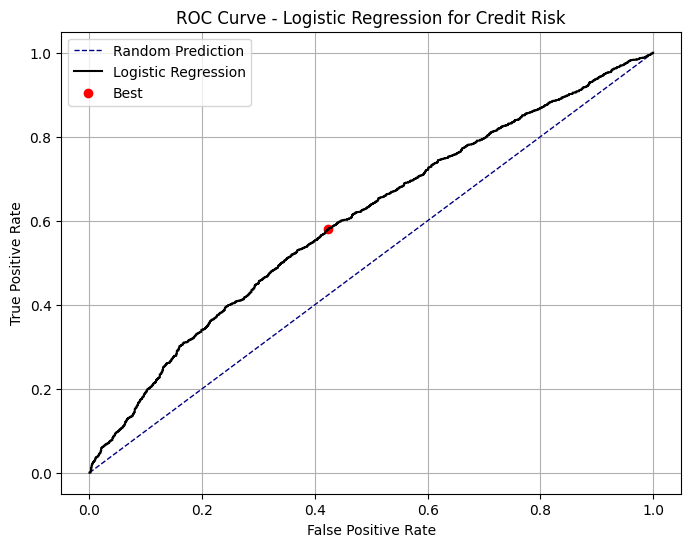

AUC Score      :  0.6019670358405561
Best Threshold :  0.8147754855338573


In [103]:
# Step 5: Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label='Random Prediction')  # Baseline
plt.plot(lr_fpr, lr_tpr, color="black", label='Logistic Regression')  # Model ROC Curve
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='red', label='Best')  # Optimal Threshold

# Step 6: Label the axes and add a legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("ROC Curve - Logistic Regression for Credit Risk")
plt.grid(True)

# Step 7: Show the plot
plt.show()

# Step 8: Print the AUC score and optimal threshold
print("AUC Score      : ", lr_auc)
print("Best Threshold : ", thresholds[ix])


### AUC Score Measures Ranking, Not Classification

Imagine the following output using a **machine learning model** to predict which customers will **default** on a loan.  

Your model assigns **a probability score** to each customer, representing how likely they are to **default (1)** or **not default (0)**.  

**Example: Predicted Probabilities vs. Actual Defaults**  

| Customer | Actual Label (0 = No Default, 1 = Default) | Predicted Probability |
|----------|-----------------|----------------------|
| A        | 1 (Default)      | 0.95 |
| B        | 0 (No Default)   | 0.85 |
| C        | 1 (Default)      | 0.75 |
| D        | 0 (No Default)   | 0.60 |
| E        | 1 (Default)      | 0.40 |
| F        | 0 (No Default)   | 0.20 |


**What Does AUC Measure?**

The **AUC score** answers the question:  

*"How often does the model assign a higher probability to a Default (1) than to a No Default (0)?"*  

**Let’s compare every positive case (1) against every negative case (0):**  

| Positive (Default = 1) | Negative (No Default = 0) | Is Default Ranked Higher? |
|------------------------|--------------------------|---------------------------|
| **A (0.95)**  | **B (0.85)**  | ✅ Yes |
| **A (0.95)**  | **D (0.60)**  | ✅ Yes |
| **A (0.95)**  | **F (0.20)**  | ✅ Yes |
| **C (0.75)**  | **B (0.85)**  | ❌ No (Mistake) |
| **C (0.75)**  | **D (0.60)**  | ✅ Yes |
| **C (0.75)**  | **F (0.20)**  | ✅ Yes |
| **E (0.40)**  | **B (0.85)**  | ❌ No (Mistake) |
| **E (0.40)**  | **D (0.60)**  | ❌ No (Mistake) |
| **E (0.40)**  | **F (0.20)**  | ✅ Yes |

🔹 The model **correctly ranks defaults above non-defaults in most cases**.  

🔹 **But it makes some mistakes**, where it gives a lower probability to a default than to a non-default (e.g., C vs. B, E vs. B).  


**Why AUC Does NOT Depend on a Fixed Threshold**
- If we choose **threshold = 0.5**, we might classify **A, C, and E** as "default" and **B, D, and F** as "no default."
- If we change **threshold = 0.7**, we only classify **A and C** as "default."

👉 **Changing the threshold changes how we classify customers, but it does not change the ranking order of probabilities.**  

🔹 **Example:**
- No matter which threshold we use, **A (0.95) will always be ranked higher than E (0.40)**.
- The **AUC-ROC only cares about ranking**, not about how we decide to label each case.

**Key Takeaways**

✅ **AUC measures how well the model ranks positive cases above negative ones.**  

✅ **It does NOT depend on a specific classification threshold (e.g., 0.5, 0.7, etc.).**  

✅ **A high AUC means the model is good at ranking positive cases higher than negative ones, regardless of the cutoff used.**  

## References and Credits

John C. Hull, **Machine Learning in Business: An Introduction to the World of Data Science**, Amazon, 2019.

Paul Wilmott, **Machine Learning: An Applied Mathematics Introduction**, Panda Ohana Publishing, 2019.

## Appendix

### **Newton-CG Method for Optimization**

The **Newton-CG (Newton-Conjugate Gradient) method** is an **iterative optimization algorithm** used to solve **non-linear optimization problems**, particularly for **logistic regression** and other models where the cost function involves second-order derivatives.

**1. How Does Newton-CG Work?**

The Newton-CG method is a variant of **Newton’s Method**, which is designed to find the optimal parameters $ \theta $ that minimize a given cost function $ J(\theta) $. Instead of using **gradient descent**, it leverages **second-order derivatives (Hessian matrix)** to take more informed steps toward convergence.

In standard **Newton’s Method**, the update rule for the parameters is:

$$
\theta^{(t+1)} = \theta^{(t)} - H^{-1} \nabla J(\theta^{(t)})
$$

where:
- $ \nabla J(\theta) $ is the **gradient (first derivative)** of the cost function.
- $ H $ is the **Hessian matrix (second derivative)** of the cost function.
- $ H^{-1} $ is the **inverse of the Hessian**, which provides a better estimate of the optimal step size.

However, computing $ H^{-1} $ directly can be computationally expensive, especially for large datasets with many features.


**2. Why Use Conjugate Gradient (CG)?**

Instead of explicitly inverting the Hessian matrix, Newton-CG **solves the system $ H \Delta\theta = -\nabla J(\theta) $ iteratively using the Conjugate Gradient method**. This makes it:
- **More efficient** for high-dimensional problems (e.g., logistic regression with many features).
- **Faster than standard Newton’s method**, especially when the number of features is large.
- **More stable** than gradient descent, since it uses second-order information to avoid slow convergence or vanishing gradients.


**3. Application in Logistic Regression**

In logistic regression, the cost function is based on the **log-likelihood function**:

$$
J(\theta) = - \sum_{i=1}^{n} \left[y_i \log(h_\theta(x_i)) + (1 - y_i) \log(1 - h_\theta(x_i))\right]
$$

where $ h_\theta(x) $ is the **sigmoid function**:

$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

- The **gradient** $ \nabla J(\theta) $ gives the direction of steepest ascent.
- The **Hessian matrix** $ H $ provides information about the curvature of the function.
- Newton-CG iteratively refines $ \theta $ by solving $ H \Delta\theta = -\nabla J(\theta) $ without explicitly computing $ H^{-1} $.


**4. Advantages of Newton-CG**

✅ **Faster Convergence**: Since it uses second-order derivatives, it typically converges in **fewer iterations** than gradient descent.  
✅ **Better Step Size Estimation**: The Hessian matrix helps adjust step sizes dynamically, avoiding issues like slow learning rates.  
✅ **Efficient for Large Datasets**: It avoids the direct computation of the Hessian inverse, making it scalable to high-dimensional data.


**5. When to Use Newton-CG?**

- When dealing with **large feature spaces** where computing the Hessian explicitly would be impractical.
- When training **logistic regression models** (as in scikit-learn, where it is one of the supported solvers).
- When looking for **faster convergence** compared to simple gradient descent methods.


**6. Comparison with Other Solvers in Logistic Regression**

| **Solver**         | **Uses Second Derivatives?** | **Best for Large Datasets?** | **Regularization Supported?** | **Notes** |
|--------------------|----------------------------|-----------------------------|------------------------------|-----------|
| **liblinear**      | ❌ No  | ✅ Yes  | ✅ Supports L1 & L2 | Good for small datasets |
| **lbfgs**         | ✅ Yes (Approximated) | ✅ Yes  | ✅ Supports L2 | Good for large datasets |
| **newton-cg**     | ✅ Yes  | ✅ Yes  | ✅ Supports L2 | Efficient for large feature spaces |
| **sag**           | ❌ No  | ✅ Yes  | ✅ Supports L2 | Stochastic, good for large datasets |
| **saga**          | ❌ No  | ✅ Yes  | ✅ Supports L1 & L2 | Similar to SAG, supports L1 |


**7. Conclusion**

The **Newton-CG** method is an advanced optimization technique used in **logistic regression** to efficiently find model parameters by leveraging second-order derivatives without explicitly computing the Hessian inverse. It is particularly useful for large feature spaces, where direct Newton’s Method is computationally infeasible. While it converges faster than basic gradient descent methods, it is mostly recommended when dealing with **high-dimensional datasets** where **regularization is required** to prevent overfitting.